# Árboles de decisión II
## author: Virginia Ordoño Bernier
## date: february 2024

En este ejercicio se aplican diferentes modelos de árboles del decisión al dataset California Housing (regresión):
1. Arbol de decisión
2. Random forest
3. Gradient boosting

Además hay que indicar la importancia de cada característica.

### 1. Gestión de datos

#### 1.1 Carga y creación del dataframe

In [21]:
import pandas as pd
import inflection
from sklearn.datasets import fetch_california_housing

# Descarga el conjunto de datos
housing = fetch_california_housing()
X = housing.data
y = housing.target

# Convertir los datos en DataFrame y cambiar nombre columnas
df_housing = pd.DataFrame(data=X, columns=housing.feature_names)
df_housing.columns = [inflection.underscore(col.replace(' ', '_').replace('(', '').replace(')', '')) for col in df_housing.columns]

# Agrega target
df_housing['target'] = y

df_housing.head()


,med_inc,house_age,ave_rooms,ave_bedrms,population,ave_occup,latitude,longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [22]:
print(f'Filas: {df_housing.shape[0]}')
print(f'{df_housing.isna().sum()}')

Filas: 20640
med_inc       0
house_age     0
ave_rooms     0
ave_bedrms    0
population    0
ave_occup     0
latitude      0
longitude     0
target        0
dtype: int64


#### 1.2 Histograma

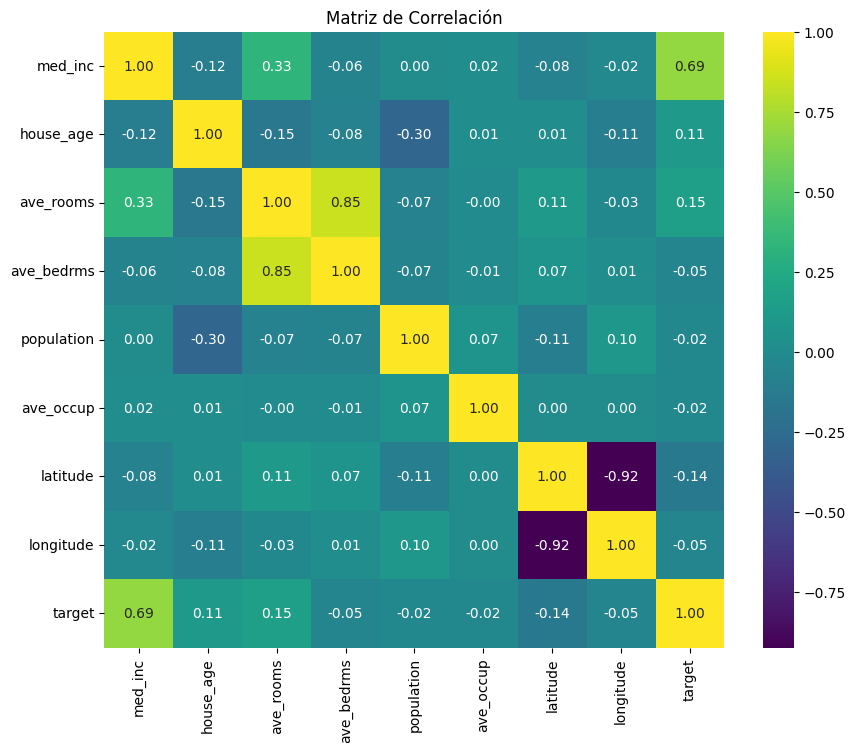

            med_inc  house_age  ave_rooms  ave_bedrms  population  ave_occup  \
med_inc        1.00      -0.12       0.33       -0.06        0.00       0.02   
house_age     -0.12       1.00      -0.15       -0.08       -0.30       0.01   
ave_rooms      0.33      -0.15       1.00        0.85       -0.07      -0.00   
ave_bedrms    -0.06      -0.08       0.85        1.00       -0.07      -0.01   
population     0.00      -0.30      -0.07       -0.07        1.00       0.07   
ave_occup      0.02       0.01      -0.00       -0.01        0.07       1.00   
latitude      -0.08       0.01       0.11        0.07       -0.11       0.00   
longitude     -0.02      -0.11      -0.03        0.01        0.10       0.00   
target         0.69       0.11       0.15       -0.05       -0.02      -0.02   

            latitude  longitude  target  
med_inc        -0.08      -0.02    0.69  
house_age       0.01      -0.11    0.11  
ave_rooms       0.11      -0.03    0.15  
ave_bedrms      0.07       0.01

In [23]:
# Crear una matriz de correlación
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_housing.corr()

# Visualizar la matriz de correlación utilizando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

# Imprimir la matriz de correlación con redondeo a 2 decimales
# print("Matriz de Correlación:")
print(correlation_matrix.round(2))

## 1.3. Lectura correlación

Correlación fuerte positiva:
- target <=> med_inc (ingreso medio). Si el ingreso medio aumenta, la variable objetivo también tiende a aumentar.

Correlación fuerte negativa:
target <=> house_age, latitude y longitude. Si las variables disminuyen, la variable objetivo tiende a aumentar ligeramente.

Multicolinealidad
ave_rooms <=>  ave_bedrms (0.85). Esto puede afectar la interpretación de los coeficientes en un modelo de regresión y podría ser algo a tener en cuenta al seleccionar variables predictoras.

Poca correlación
target <=> population y ave_occup. Pueden no ser tan importantes en la predicción de la variable objetivo.

### 1.3. Preparación de datos para el entrenamiento

In [24]:
from sklearn.model_selection import train_test_split

X = df_housing.drop('target', axis=1)
y = df_housing['target']

# Divide el DataFrame en conjuntos de entrenamiento y prueba 
train, test = train_test_split(df_housing, test_size=0.33, random_state=42)

# Reseteo de índices
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Separación características y etiquetas
X_train = train.drop('target', axis=1)  
y_train = train['target']  
X_test = test.drop('target', axis=1)  
y_test = test['target']

print("Conjunto de entrenamiento:")
print(X_train.head()) 

print("\nConjunto de prueba:")
print(X_test.head())  


Conjunto de entrenamiento:
   med_inc  house_age  ave_rooms  ave_bedrms  population  ave_occup  latitude  \
0   0.9809       19.0   3.187726    1.129964       726.0   2.620939     33.98   
1   4.2232       33.0   6.189696    1.086651      1015.0   2.377049     37.46   
2   3.5488       42.0   4.821577    1.095436      1044.0   4.331950     33.79   
3   1.6469       24.0   4.274194    1.048387      1686.0   4.532258     35.87   
4   3.9909       14.0   4.608303    1.089350      2738.0   2.471119     37.54   

   longitude  
0    -118.28  
1    -122.23  
2    -118.26  
3    -119.26  
4    -121.96  

Conjunto de prueba:
   med_inc  house_age  ave_rooms  ave_bedrms  population  ave_occup  latitude  \
0   1.6812       25.0   4.192201    1.022284      1392.0   3.877437     36.06   
1   2.5313       30.0   5.039384    1.193493      1565.0   2.679795     35.14   
2   3.4801       52.0   3.977155    1.185877      1310.0   1.360332     37.80   
3   5.7376       17.0   6.163636    1.020202      1

## MODELO: ÁRBOL DE DECISIÓN (CLASIFICACIÓN)

#### Selección de mejor profundidad quitando características con poca correlación

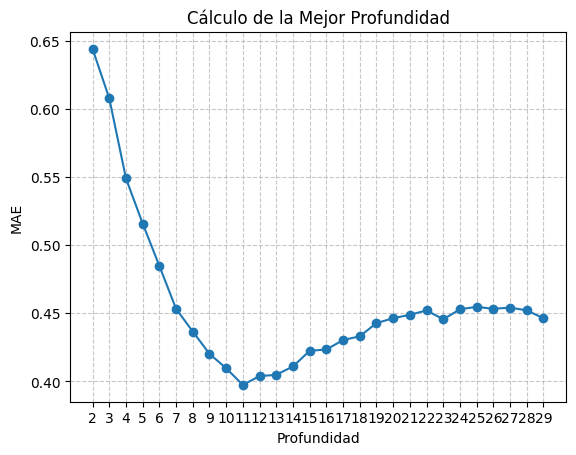

Mejor Profundidad: 11
Menor MAE: 0.40


In [25]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

selected_features = ['med_inc', 'house_age', 'ave_rooms', 'ave_bedrms', 'latitude', 'longitude']

mae_list = []

for i in range(2, 30):
    model = DecisionTreeRegressor(max_depth=i, criterion='absolute_error', random_state=0)
    model.fit(X_train[selected_features], y_train)
    y_pred = model.predict(X_test[selected_features])
    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)

min_mae_index = mae_list.index(min(mae_list))
best_depth = range(2, 30)[min_mae_index]
min_mae = min(mae_list)

# Plot mae
plt.plot(range(2, 30), mae_list, marker='o')
plt.title('Cálculo de la Mejor Profundidad')
plt.xlabel('Profundidad')
plt.ylabel('MAE')

# Configurar etiquetas en el eje x para mostrar todos los valores
plt.xticks(range(2, 30))

# Añadir cuadrículas de fondo
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

print(f'Mejor Profundidad: {best_depth}\nMenor MAE: {min_mae:.2f}')


### Validación cruzada

In [28]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

cv = KFold(n_splits = 5)

total_scores = []
best_depth = None

# Infinite float. For minimizing Mean Absolute Error.
# min_mae = float('inf') asegura que cualquier MAE encontrado en las primeras iteraciones del bucle 
# será menor que min_mae, por lo que se actualizará. 
min_mae = float('inf')

# Trying with different depths
for i in range(1, 30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i, criterion='absolute_error', random_state=42)

    for train_fold, test_fold in cv.split(train[selected_features]):
        
        # Divide train and test groups
        f_train = train.iloc[train_fold] # train_fold index, selects a row. F_train is a new df 
        f_test = train.iloc[test_fold] # test_fold index, selects a row. F_test is a new df
        
        # Train the model on the current fold
        dt.fit(
            X = f_train.drop(['target'], axis = 1), # thorugh the column
            y = f_train['target']
        )
        X_test = f_test.drop(['target'], axis = 1) # thorugh the column
        y_pred = dt.predict(X_test)
        
        # Evaluation
        mae = mean_absolute_error(f_test['target'], y_pred)
        fold_accuracy.append(mae)
    
    # Calculate and store the average accuracy for the current depth
    avg_mae = np.mean(fold_accuracy)
    total_scores.append(avg_mae)

    # Check if the current depth results in a lower MAE
    if avg_mae < min_mae:
        min_mae = avg_mae
        best_depth = i

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), total_scores, marker='o', linestyle='-', color='b')
plt.title('Validación cruzada para obtener mejor profundidad')
plt.xlabel('Máxima Profundidad')
plt.ylabel('Promedio del Error Absoluto Medio')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

# Print the results
print(f"Mejor profundidad: {best_depth}")
print(f"Menor Valor de Error Absoluto Medio: {min_mae}")

## Contrucción del modelo con la mejor profundidad

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Construcción del modelo
model = DecisionTreeRegressor(criterion='absolute_error', max_depth=best_depth, random_state=0)

# Entrenamiento
# doble [] para convertirlo en un df ya que es solo una columna 
model.fit(X_train[['temperature', 'humidity', 'windspeed']], y_train)

# Predicción
y_pred = model.predict(X_test[['temperature', 'humidity', 'windspeed']])

# Evaluación
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE en el conjunto de prueba: {round(mae, 2)}')

## Importancia de las variables

In [ ]:
features_names = selected_features

# Cargamos la importancia de las características
importances = model.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({'Características':features_names, 'Importancia': importances})

# Order by importance
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# Mostramos
print("Informe de Importancia de las Variables:")
print(feature_importance_df)

# Gráfico de importancia de las variables
colors = ['red', 'green', 'blue', 'orange', 'purple']
plt.bar(features_names, importances, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Variables predictoras')
plt.ylabel('Importancia')
plt.title('Gráfico de importancia de las variables')
plt.show()

## Visualización del árbol con todas las características

In [ ]:
from IPython.display import Image
from sklearn import tree

# Crear un archivo DOT que representa el árbol de decisión (en este caso se devuelve como cadena)
dot_data = tree.export_graphviz(model, out_file=None,
                    feature_names = features_names,
                    rounded = True, filled = True, special_characters=True)

# Generar el gráfico del árbol de decisión desde el archivo DOT
graph = graphviz.Source(dot_data)

# Mostrar el gráfico en Jupyter Notebook o en un archivo
#graph.view("arbol_de_decision")  # Esto guardará el gráfico en un archivo llamado "arbol_de_decision.pdf"
display(graph)